In [2]:
import torch
import math
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.datasets import make_friedman1

# Introducció

Avui començarem a fer feina amb **Pytorch**, ja que la segona part del curs tracta de xarxes neuronals profundes. Aquesta és una biblioteca de programari de codi obert dins l'àmbit d'aprenentatge automàtic, esta escrita en _Python_, _C++_ i _CUDA_, i basada en la biblioteca del programari _Torch_ del llenguatge _LUA_. **PyTorch** va ser desenvolupada inicialment pel departament d'intel·ligència artificial de l'empresa Facebook i l'empresa Uber.

Començarem a conèixer aquesta llibreria mitjançant l'execució d'un exemple. 

## Generació de les dades
Per fer aquest tutorial emprarem un conjunt de dades que s'autogenera a partir de certs paràmetres, la variable a predir es correspon amb la següent fórmula:

$y(X) = 10 * \sin(\pi * X[0] * X[1]) + 20 * (X[2] - 0.5)^2 + 10 * X[3] + 5 * X[4] + noise * N(0, 1).$

Com podeu observar en la fórmula anterior, tenim 5 variables útils, a més nosaltres en generarem 5 més per dificultar una mica el problema. Ens trobem davant un problema de regressió en el que haurem d'aconseguir que la xarxa aprengui a predir els valors de $y$ a partir dels 10 valors que es corresponen amb una observació.

[Més informació](https://projecteuclid.org/journals/annals-of-statistics/volume-19/issue-1/Multivariate-Adaptive-Regression-Splines/10.1214/aos/1176347963.full)

Si executau el codi següent obtindreu el conjunt de dades amb els dos conjunts que empram per entrenar:

In [3]:
X, y = make_friedman1(n_samples=2000, n_features=10, noise=0.0, random_state=33)

X = torch.tensor(X, dtype=torch.float32) # ho passam al tipus de dades de Pytorch
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33,shuffle=True)


## Definició de la xarxa

El mòdul [torch.nn](https://pytorch.org/docs/stable/nn.html) conté els blocs basics per la construcció de les xarxes. Utilitzarem el contenidor `nn.Sequential` per definir el nostre model com una seqüència de capes que s'executen una rere l'altre. Recordeu que una xarxa no és més que un graf dirigit acíclic.
 
Aquest és un mòdul que conté altres mòduls i els aplica en seqüència per produir una sortida. El mòdul lineal `nn.Linear` calcula la sortida de l'entrada mitjançant una funció lineal i opera els tensors interns pel seu pes i biaix. La capa ``nn.Flatten`` "aplana" la sortida de la capa lineal a un tensor 1D, perquè coincideixi amb la dimensionalitat que necessitem a la sortida.

A més de la xarxa també definirem els paràmetres de l'entrenament. En aquest cas:

- **Funció de pèrdua**: És la funció que volem minimitzar mitjançant l'entrenament. En aquest cas emprarem el error quadratic mitjà (MSE):$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2, $ on $y_i$ són els valors reals, $\hat{y}_i$ són els valors predits i $n$ el nombre de mostres.
- **Rati d'aprenentatge** (_Learning Rate_): Representa la velocitat o el pas amb el qual un model d'aprenentatge automàtic ajusta els pesos i els paràmetres durant el procés d'entrenament. És equivalent al paràmetre `eta` del perceptró.
- **Algorisme d'Optimització**: Tècnica que s'empra per ajustar els pesos i paràmetres d'un model durant el procés d'entrenament. El seu objectiu principal és minimitzar la funció de pèrdua del model. Els optimitzadors determinen com s‟actualitzen els paràmetres del model en funció de l'error calculat (és dependent de la funció de pèrdua elegida). Nosaltres usarem [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) per ser l'algorisme més emprat en l'actualitat. 

In [14]:
model = torch.nn.Sequential(torch.nn.Linear(10, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 1)) #Hem definit un perceptró

loss_fn = torch.nn.MSELoss() 

learning_rate =  1e-3 # Hiperparàmetre

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Entrenament

Amb **Pytorch** hem de definir el nostre propi bucle d'entrenament, en el qual haurem de realitzar totes les passes d'una iteració:

1. Predicció
2. Càlcul del valor de la pèrdua
3. Còmput del gradient respecte als paràmetres del model.
4. Actualització dels pesos del model

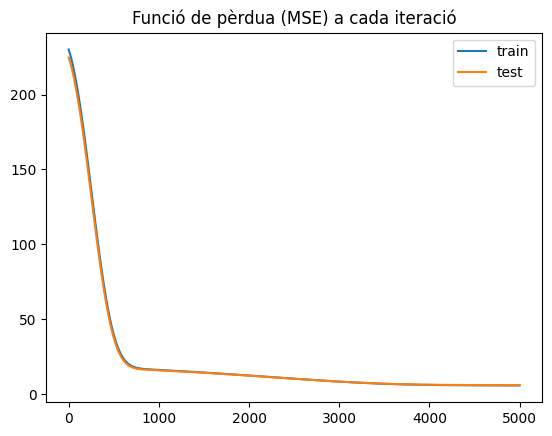

In [15]:
iter = 5000  #nombre d'iteracions de l'entrenament
loss_p = np.zeros(iter)  # guardam la pèrdua de cada iteració
loss_test = np.zeros(iter)  # guardam la pèrdua de cada iteració

for t in range(iter):
    # 1. PREDICCIÓ
    # Passat endavant: calcula la y, fa la predicció passant x al model. 
    model.train()
    y_pred = model(X_train)
    
    #print(y_pred.shape)
    # 2. CALCUL DE LA PÈRDUA
    # Computa la pèrdua: l'error de predicció vs el valor correcte
    # Es guarda la pèrdua en un array per futures visualitzacions
    loss = loss_fn(y_pred, y_train)
    loss_p[t] = loss.item()
    
    #3. GRADIENT
    # Posa a 0 els gradients del model per poder fer la passa enrere
    model.zero_grad()

   # Passa enrere: calcula el gradient de la pèrdua respecte a tots els paràmetres del model. 
   # Internament, s'emmagatzemen els paràmetres de cada mòdul a Tensors amb el paràmetere requires_grad=True, d
   # de manera que aquesta crida calcularà gradients per tots els paràmetres del model.
    loss.backward()

    # Actualitza els pesos utilitzant l'algorisme d'actualització
    #4. OPTIMITZACIO
    with torch.no_grad():
        optimizer.step()

    model.eval()

    y_pred_test = model(X_test)
    loss = loss_fn(y_pred_test, y_test)
    loss_test[t] = loss.item()

# Mostram resultats
plt.title("Funció de pèrdua (MSE) a cada iteració")
plt.plot(loss_p, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.show()

### TODO

Si pensam una mica, la funció que estam minimitzant durant l'entrenament és justament la mètrica que empraríem per avaluar la nostra xarxa amb el conjunt de test.
 
Es demana que incorporeu l'avaluació del conjunt de test en el bucle anterior i mostreu el valor final per pantalla.